In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS
import numpy as np
import pandas as pd
# %cd /home/user_3/medistream-recsys/Script
# from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_json('/home/user_4/CBF/article_sum.json')
df = df.copy()
df.shape

(3438, 5)

In [3]:
# CBF -> 아티클의 갯수 book and article 사용할 수 있는 feature

In [61]:
df = pd.read_json('/fastcampus-data/select_column_version_3.json')
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# # 3개월치 데이터만 가져오기
# df_date = df_only_paid[df_only_paid['date_paid'] > "2022-05-12"]
# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]
complete_df = complete_df.reset_index(drop=True)
# 도서 카테고리만 가져오기
# df = complete_df[complete_df['name'] == '도서']
df = complete_df.sort_values(by='date_paid')
df

,_id,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
10,5d6240e84e77525ec5ca1597,2019-08-26 02:41:49.952000+00:00,5d60d6ef4e77525ec5ca147b,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,30-39,1.0,1.0,False,의약품,medicine
182,5d60d84a4e77525ec5ca1488,2019-08-26 02:41:49.990000+00:00,5d60d7eb4e77525ec5ca1485,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,50-59,1.0,1.0,False,의약품,medicine
26,5d60e8ee4e77525ec5ca14bd,2019-08-26 02:41:49.991000+00:00,5d60e8dd4e77525ec5ca14b9,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,40-49,1.0,1.0,False,의약품,medicine
25,5d60dc3a4e77525ec5ca14a1,2019-08-26 02:41:49.992000+00:00,5d60dc374e77525ec5ca14a0,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,30-39,1.0,1.0,False,의약품,medicine
63,5d60dec54e77525ec5ca14b2,2019-08-26 02:41:50.002000+00:00,5d60de9e4e77525ec5ca14af,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,20-29,1.0,0.0,False,의약품,medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173908,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 형개[수] 600g, 중국",5fb32f7a5120316334323fd8,5fb769825120316334324abc,1.0,11400.0,11400.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173909,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 황기(편) (5묶음) 600g*5ea, 중국",5fb32f7a5120316334323fd8,620c771fd41623002392d61b,1.0,35200.0,35200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173910,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 어성초 600g, 중국",5fb32f7a5120316334323fd8,5fb769575120316334324a69,1.0,4200.0,4200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173911,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 여정실 600g, 중국",5fb32f7a5120316334323fd8,5fb769585120316334324a6a,1.0,3300.0,3300.0,30-39,0.0,1.0,False,한약재,medicinal-herbs


In [4]:
df_article = pd.read_json('/fastcampus-data/articles/articels_only_contents.json')
df_book = pd.read_json('/home/user_1/medistream-recsys/Script/YS/df_book_clean.json')
df_book

,_id,category_id_x,date_created,name_x,description,meta_description_x,meta_title,tags_x,three_months,regular_price_y,m_name,L_name,s_name,book_corpus,book_corpus_konlp
0,5d13115e32026c0b35383897,5cf8bbba0098b2225c5dfaa3,{'$date': '2019-06-26T06:31:58.090Z'},KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...,진료에 어려움 있을 때 먼저 찾는 책,KCD 한방내과 진찰진단 가이드라인,[가온해미디어],35,150000.0,전문,도서,[가온해미디어],"KCD 한방내과 진찰진단 가이드라인, 의 번째 큐레이션 상시판매 권승원의 한방내과...","[정리, 보험, 션, 현장, 년, 참고, 신부전, 다작, 위해, 대한, 제시, 의,..."
1,5d9edfe70dabe405b156e213,5cf8bbba0098b2225c5dfaa3,{'$date': '2019-10-10T07:38:15.467Z'},우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...,약물남용과 과잉치료가 없는 새로운 감기 진료를 목표로,우리 아이 감기,[물고기숲],7,NaN,None,None,None,"우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를...","[기적, 소아과학, 왜곡, 위해, 초음파, 가장, 모두, 삼, 보호자, 중증, 폐렴..."
2,5e3cb2904267e105dfff13b3,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T00:42:56.629Z'},통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...,하이드로다이섹션: 포도당을 이용한 신경의 유착박리와 신경주변 환경개선,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,[메디안북],2,190000.0,전문,도서,[메디안북],"통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉, _ 출판사 리뷰년전 소수...","[골반, 불씨, 부, 모임, 현장, 유착, 밸런스, 좌, 관절, 척수, 배늑, 위해..."
3,5e3d06b64267e105dfff13e0,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T06:41:58.622Z'},의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서,,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),[메디안북],0,130000.0,전문,도서,[메디안북],"의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야...","[실전, 알, 의사, 꼭, 지침, 응급의학]"
4,5e3d0da94267e105dfff13ed,5cf8bbba0098b2225c5dfaa3,{'$date': '2020-02-07T07:11:37.566Z'},복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...,정확한 복부초음파를 위한 필독서,복부 초음파 정석,[메디안북],1,60000.0,전문,도서,[메디안북],"복부 초음파 정석, _ 저자서문 초음파 검사는 임상 영역에서 청진기로 ...","[주, 초음파, 성능, 장단점, 알코올, 한눈, 만성, 모두, 직경, 김현정, 효율..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,63182f4a6c2e37002369d6b9,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:34.413Z'},임상족부학과 족부보조기,저자 서문중부족한 실력이지만 여기저기 다니며 족부학에 대해 강의하다 보니 마지막...,,임상족부학과 족부보조기,[대한의학서적],0,70000.0,전문,도서,[대한의학서적],"임상족부학과 족부보조기, 저자 서문중부족한 실력이지만 여기저기 다니며 족부학에 대...","[인지, 앞서, 정리, 마지막, 비가역, 교재, 보험, 생각, 여기저기, 대해, 년..."
371,63182f4b6c2e37002369d6ba,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:35.702Z'},기능의학적 시각으로 비만관리 시작하기,저자 서문중지구상의 인구 중에 이 비만이라니 정말 놀라운 일이다 아마 시간이 흐...,비만관리를 위한 새로운 각도의 접근법,기능의학적 시각으로 비만관리 시작하기,[대한의학서적],0,40000.0,전문,도서,[대한의학서적],"기능의학적 시각으로 비만관리 시작하기, 저자 서문중지구상의 인구 중에 이 비만이라...","[조금, 투여, 권유, 년, 상담, 이처럼, 볼, 궁금증, 대한, 사람, 정말, 식..."
372,63182f4c6c2e37002369d6bb,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:36.934Z'},일차진료 Clinical Manual 7판,일차진료 판 일차진료 판본 매뉴얼은 년 「영동 매뉴얼」이라는 제목의...,일차진료 클리니컬 매뉴얼,일차진료 Clinical Manual 7판,[대한의학서적],0,50000.0,경영,도서,[대한의학서적],"일차진료 Clinical Manual 7판, 일차진료 판 일차진료 판본...","[눈꺼풀, 재, 특이, 위해, 림프구, 미리보기, 알코올, 손목, 만성, 가장, 모..."
373,63182f4d6c2e37002369d6bc,5cf8bbba0098b2225c5dfaa3,{'$date': '2022-09-07T05:42:37.928Z'},醫學心悟(의학심오) 톺아보기,고전에서 배우는 한의치료 오뒷세이아① 《醫學心悟는 청대 초...,고전에서 배우는 한의치료 오뒷세이아①,醫學心悟(의학심오) 톺아보기,[물고기숲],1,45000.0,전문,도서,[물고기숲],"醫學心悟(의학심오) 톺아보기, 고전에서 배우는 한의치료 오뒷세이...","[면, 의료, 섭렵, 정리, 일본, 팔다리, 기적, 중의학, 치법, 생각, 년, 산..."


In [5]:
df_article.shape, df_book.shape # 빈 row 제거 후 사용 data

((3438, 36), (372, 15))

In [6]:
df_article['content_tag_removed'] # tag 제거 후의 feature

0        케이스의 종류  치료성공 케이스     환자 성별, 나이  여자 / 30대 후반 ...
1        수고하십니다.  자보환자가 한약 치료 끝나고 보험제제를 계속 원하십니다.  저희 ...
2         케이스의 종류    치료 성공 케이스       환자 성별, 나이    남자 /...
3            한의원에서 대응해서 할 수 있는 치료주사기로 빼야 하는지 등는 무엇이 있나요? 
4         케이스의 종류    함께 논의하고 싶은 케이스       환자 성별, 나이   ...
                              ...                        
3433         선생님들 안녕하세요!      꽤 오랜만에 글을 씁니다.  저 퇴사를 했습...
3434      # CASE 13 houlder iigeet yd. SASD uriti   37...
3435     얼마 전 COVID-19를 앓고 난 뒤 남아 있는 여러 증상들, 롱 코비드Log ...
3436     여름 휴가 기간은 쏜살같이 지났고, 여전히 메디스트림은 바쁘다.     엎친데 덮...
3437     행복한 추석명절 보내세요!!     ce 16. rottor cuff tedo의 ...
Name: content_tag_removed, Length: 3438, dtype: object

In [7]:
df_book['description'] # tag 제거 후의 feature

0       의 번째 큐레이션 상시판매  권승원의 한방내과 진찰진단 가이드라인   의학은빠른속...
1      우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로     ...
2          _ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...
3                            의사들이 꼭 알고 있어야 하는 응급의학 실전지침서
4           _   저자서문  초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...
                             ...                        
370      저자 서문중부족한 실력이지만 여기저기 다니며 족부학에 대해 강의하다 보니 마지막...
371      저자 서문중지구상의 인구 중에 이 비만이라니 정말 놀라운 일이다 아마 시간이 흐...
372        일차진료   판 일차진료   판본 매뉴얼은 년 「영동  매뉴얼」이라는 제목의...
373                고전에서 배우는 한의치료 오뒷세이아①   《醫學心悟는 청대 초...
374      저자 서문중피부과학을 전공하는 의과대학 교수로서 의과대학원생들이나 피부과를 전공...
Name: description, Length: 372, dtype: object

In [8]:
df_order = pd.read_json('/fastcampus-data/all_column_version_3.json')

In [11]:
# paid orders만 가져오기
df_order['date_paid'] = pd.to_datetime(df_order['date_paid'])
df_only_paid = df_order[~df_order['date_paid'].isna()]
# # 3개월치 데이터만 가져오기
# df_date = df_only_paid[df_only_paid['date_paid'] > "2022-05-12"]
# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]
complete_df = complete_df.reset_index(drop=True)
# 도서 카테고리만 가져오기
df_book = complete_df[complete_df['name'] == '도서']
df_book = df_book.sort_values(by='date_paid')


In [12]:
df_book.shape

(38395, 68)

# 많이 산 유저

In [ ]:
df

In [63]:
# 1인당 평균 구매
# 총 책 거래수/전체 고객 unique값

len(df_book),df['customer_id'].nunique(),len(df_book)/df['customer_id'].nunique()

(38395, 13519, 2.8400769287669205)

In [19]:
vip_list = df_book['customer_id'].value_counts()[:100].index

In [22]:
df_vip = df_book[df_book['customer_id'].isin(vip_list)]

In [44]:
df_vip['customer_id'].value_counts()

5d970b4f0dabe405b156dce4    130
5dae9a8d0dabe405b156efd0    100
5f54931ea0b91001bf48f3f9     96
5f2f5d9ba0b91001bf48bc0f     95
5ebc8bee09982e0735b2d835     90
5df0c0a44267e105dffef407     82
5d60eef64e77525ec5ca14c7     75
5d69cd4319efa30eb2913de3     68
5d96a3b40dabe405b156dadf     67
5d86d45a0dabe405b156d41d     65
5d931e5d0dabe405b156d67a     64
5d68633d19efa30eb2913d54     63
5d752eaf19efa30eb2914394     63
5fd2cf361c6ef3001a115165     62
5f7d8c8748060c52caf1635e     61
5d9719490dabe405b156dd26     60
5dafaccd0dabe405b156f1b3     60
5e94323fbfe426094478562d     59
5d931dd20dabe405b156d65f     57
5d931d770dabe405b156d63b     57
5dae75dd0dabe405b156efab     55
5d931f160dabe405b156d68c     54
5d65cb104e77525ec5ca1703     52
5dcea5c52bb59605ca3cffd3     52
5d61ca9e4e77525ec5ca1573     51
5da03e710dabe405b156e5b0     48
5da042820dabe405b156e66a     47
5d9c0beb0dabe405b156e1de     46
5d9efe9e0dabe405b156e379     44
5da9829d0dabe405b156ed18     43
5da059460dabe405b156e72e     43
5e358a06

<AxesSubplot:xlabel='customer_id', ylabel='count'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


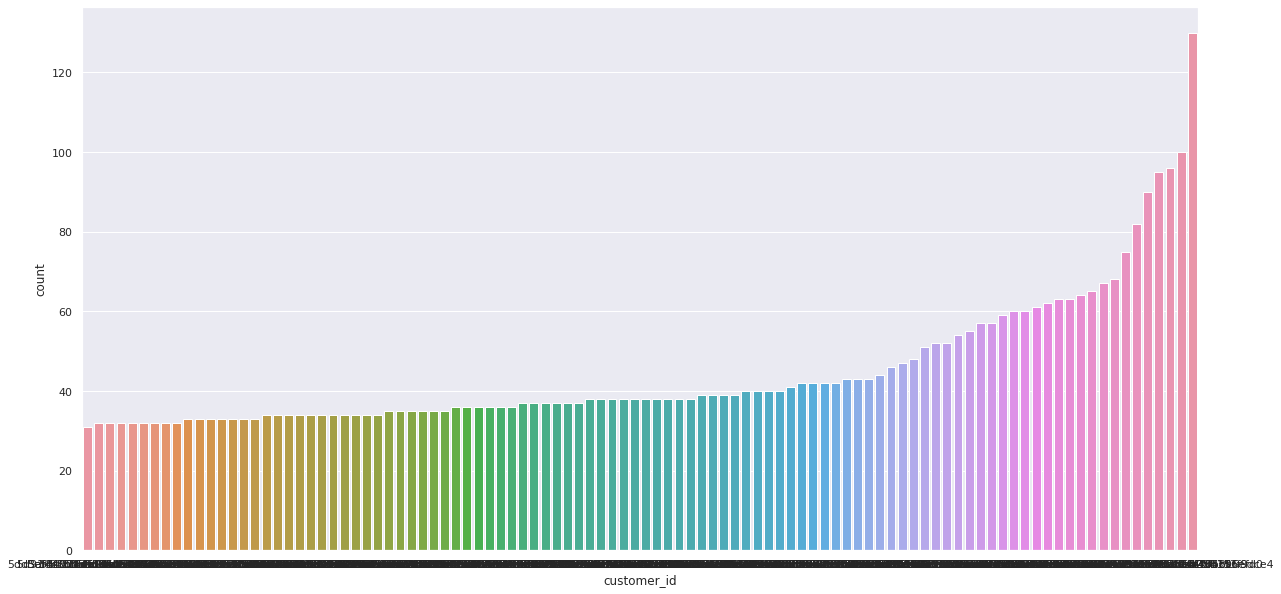

In [49]:
sns.set(rc={'figure.figsize':(15, 5)})

plt.figure(figsize=(20,10))
plt.rc('font', family='NanumGothic')
# ax = sns.barplot(data=no_promotion_book_best, x='name',y='counts')
sns.countplot(data=df_vip,x='customer_id',order=df_vip['customer_id'].value_counts().sort_values().index)

In [64]:
df_vip['customer_id'].value_counts()

5d970b4f0dabe405b156dce4    130
5dae9a8d0dabe405b156efd0    100
5f54931ea0b91001bf48f3f9     96
5f2f5d9ba0b91001bf48bc0f     95
5ebc8bee09982e0735b2d835     90
5df0c0a44267e105dffef407     82
5d60eef64e77525ec5ca14c7     75
5d69cd4319efa30eb2913de3     68
5d96a3b40dabe405b156dadf     67
5d86d45a0dabe405b156d41d     65
5d931e5d0dabe405b156d67a     64
5d68633d19efa30eb2913d54     63
5d752eaf19efa30eb2914394     63
5fd2cf361c6ef3001a115165     62
5f7d8c8748060c52caf1635e     61
5d9719490dabe405b156dd26     60
5dafaccd0dabe405b156f1b3     60
5e94323fbfe426094478562d     59
5d931dd20dabe405b156d65f     57
5d931d770dabe405b156d63b     57
5dae75dd0dabe405b156efab     55
5d931f160dabe405b156d68c     54
5d65cb104e77525ec5ca1703     52
5dcea5c52bb59605ca3cffd3     52
5d61ca9e4e77525ec5ca1573     51
5da03e710dabe405b156e5b0     48
5da042820dabe405b156e66a     47
5d9c0beb0dabe405b156e1de     46
5d9efe9e0dabe405b156e379     44
5da9829d0dabe405b156ed18     43
5da059460dabe405b156e72e     43
5e358a06

<AxesSubplot:xlabel='한의사 여부', ylabel='count'>

/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(byte

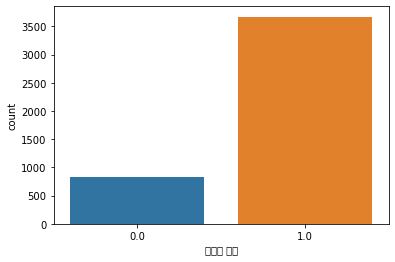

In [33]:
sns.countplot(data=df_vip,x='한의사 여부')

<AxesSubplot:xlabel='age_group', ylabel='count'>

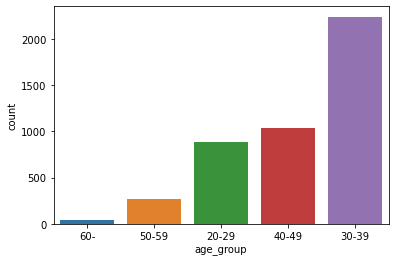

In [40]:
sns.countplot(data=df_vip,x='age_group', order=df_vip['age_group'].value_counts().sort_values().index)

In [24]:
df_vip['한의사 여부'].value_counts()

1.0    3671
0.0     826
Name: 한의사 여부, dtype: int64

In [37]:
df_vip['age_group'].value_counts().sort_values()

60-        43
50-59     265
20-29     889
40-49    1030
30-39    2238
Name: age_group, dtype: int64

In [66]:
df

,_id,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
10,5d6240e84e77525ec5ca1597,2019-08-26 02:41:49.952000+00:00,5d60d6ef4e77525ec5ca147b,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,30-39,1.0,1.0,False,의약품,medicine
182,5d60d84a4e77525ec5ca1488,2019-08-26 02:41:49.990000+00:00,5d60d7eb4e77525ec5ca1485,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,50-59,1.0,1.0,False,의약품,medicine
26,5d60e8ee4e77525ec5ca14bd,2019-08-26 02:41:49.991000+00:00,5d60e8dd4e77525ec5ca14b9,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,40-49,1.0,1.0,False,의약품,medicine
25,5d60dc3a4e77525ec5ca14a1,2019-08-26 02:41:49.992000+00:00,5d60dc374e77525ec5ca14a0,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,30-39,1.0,1.0,False,의약품,medicine
63,5d60dec54e77525ec5ca14b2,2019-08-26 02:41:50.002000+00:00,5d60de9e4e77525ec5ca14af,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,20-29,1.0,0.0,False,의약품,medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173908,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 형개[수] 600g, 중국",5fb32f7a5120316334323fd8,5fb769825120316334324abc,1.0,11400.0,11400.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173909,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 황기(편) (5묶음) 600g*5ea, 중국",5fb32f7a5120316334323fd8,620c771fd41623002392d61b,1.0,35200.0,35200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173910,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 어성초 600g, 중국",5fb32f7a5120316334323fd8,5fb769575120316334324a69,1.0,4200.0,4200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
173911,632044cb6c2e37002369f129,2022-09-13 08:53:42.268000+00:00,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 여정실 600g, 중국",5fb32f7a5120316334323fd8,5fb769585120316334324a6a,1.0,3300.0,3300.0,30-39,0.0,1.0,False,한약재,medicinal-herbs


In [68]:
df['name'].value_counts().to_frame().rename(columns={'name':'counts'})

,counts
온라인 강의,65132
도서,38395
소모품,21983
한약재,16995
식품,5580
의료기기,5494
의약품,5222
의류/잡화,3509
메디TV,2566
가전/가구,2381


In [ ]:
pd.read_json('/fastcampus-data/articles/articels_only_contents.parquet')